1. Data Preparation
2. Cluster-State Preparation (Entanglement) (Prepend)
3. Encoding Classical Data into Quantum Data: Use RY Gate for qubit rotation. 
4. Creating QCNN Layers
5. Building the Quantum-Classical Hybrid Neural Network Model


In [0]:
!pip install -q tensorflow==2.1.0

In [0]:
!pip install -q tensorflow-quantum

In [0]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

import seaborn as sns
import collections

## Data Generation

In [13]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [0]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [15]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


True


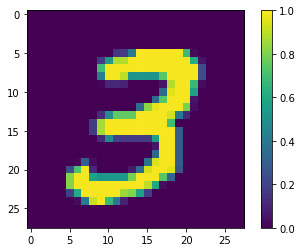

In [16]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [0]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

True


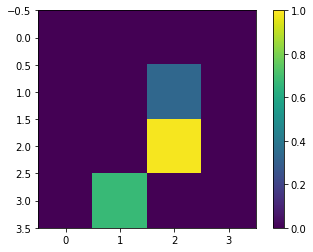

In [18]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [0]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
      labels = mapping[tuple(x.flatten())]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(list(labels)[0])
      else:
          # Throw out images that match more than one label.
          pass
    
    num_3 = sum(1 for value in mapping.values() if True in value)
    num_6 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 3s: ", num_3)
    print("Number of 6s: ", num_6)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

In [20]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of 3s:  4961
Number of 6s:  5475
Number of contradictory images:  49

Initial number of examples:  12049
Remaining non-contradictory examples:  11520


## Data Encoding - No Thresholding


In [0]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        circuit.append(cirq.rx(np.pi*value)(qubits[i])) #if value: circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_nocon]
x_test_circ = [convert_to_circuit(x) for x in x_test_small]

In [33]:
x_train_circ[0],x_train_nocon[0]

((0, 0): ───Rx(0)────────

(0, 1): ───Rx(0)────────

(0, 2): ───Rx(0)────────

(0, 3): ───Rx(0)────────

(1, 0): ───Rx(0)────────

(1, 1): ───Rx(0)────────

(1, 2): ───Rx(0.333π)───

(1, 3): ───Rx(0)────────

(2, 0): ───Rx(0)────────

(2, 1): ───Rx(0)────────

(2, 2): ───Rx(0.988π)───

(2, 3): ───Rx(0)────────

(3, 0): ───Rx(0)────────

(3, 1): ───Rx(0.675π)───

(3, 2): ───Rx(0)────────

(3, 3): ───Rx(0)────────,
 array([[[0.        ],
         [0.        ],
         [0.        ],
         [0.        ]],
 
        [[0.        ],
         [0.        ],
         [0.33333334],
         [0.        ]],
 
        [[0.        ],
         [0.        ],
         [0.9882353 ],
         [0.        ]],
 
        [[0.        ],
         [0.6745098 ],
         [0.        ],
         [0.        ]]], dtype=float32))

In [0]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [0]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

## Quantum Convolutional Neural Network

In [0]:
def cluster_state_circuit(bits):
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

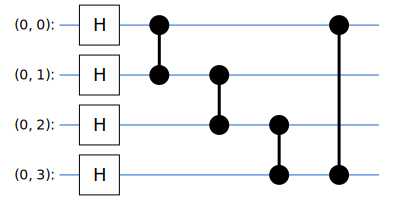

In [38]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(1, 4)))

In [0]:
def one_qubit_unitary(bit, symbols):
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

def quantum_conv_circuit(bits, symbols):
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

def quantum_pool_circuit(source_bits, sink_bits, symbols):
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

In [0]:
#SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

In [0]:
#SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

In [0]:
#SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2), sympy.symbols('x0:6')))

In [0]:
#SVGCircuit(quantum_conv_circuit(cirq.GridQubit.rect(4, 4), sympy.symbols('x0:15')))

In [0]:
#test_bits = cirq.GridQubit.rect(4, 4)
#SVGCircuit(quantum_pool_circuit(test_bits[::2], test_bits[1::2], sympy.symbols('x0:6')))   

In [0]:
def model_circuit(qubits):
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:63')

    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[::2], qubits[1::2], symbols[15:21])   #Changed the Max Pool to capture local relations better. 
                                          
    '''model_circuit += quantum_conv_circuit(qubits[4:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[4:6], qubits[6:],
                                          symbols[36:42])
    model_circuit += quantum_conv_circuit(qubits[6:], symbols[42:57])
    model_circuit += quantum_pool_circuit([qubits[6]], [qubits[7]],symbols[57:63])'''
    
    return model_circuit

In [46]:
'''qubits=cirq.GridQubit.rect(4, 4)
circuit=model_circuit(qubits)
SVGCircuit(circuit)'''

'qubits=cirq.GridQubit.rect(4, 4)\ncircuit=model_circuit(qubits)\nSVGCircuit(circuit)'

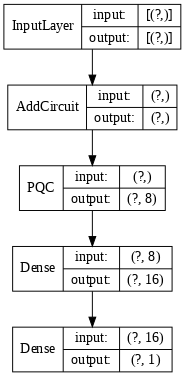

In [61]:
cluster_state_bits = cirq.GridQubit.rect(4, 4)

readouts = [cirq.Z(bit) for bit in cluster_state_bits[1::2]]


# Build a model enacting the logic in 2.1 of this notebook.
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model = tfq.layers.PQC(model_circuit(cluster_state_bits),
    readouts)(cluster_state)

d1 = tf.keras.layers.Dense(16,activation='tanh')(quantum_model)     #activation='relu'

d2 = tf.keras.layers.Dense(1,activation='tanh')(d1)

hybrid_model = tf.keras.Model(inputs=[excitation_input], outputs=[d2])

# Display the model architecture
tf.keras.utils.plot_model(hybrid_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

In [0]:
NUM_EXAMPLE=512
x_train_tfcirc=x_train_tfcirc[:NUM_EXAMPLE]
y_train_hinge=y_train_hinge[:NUM_EXAMPLE]
x_test_tfcirc=x_test_tfcirc[:NUM_EXAMPLE//4]
y_test_hinge=y_test_hinge[:NUM_EXAMPLE//4]

In [66]:
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))
    return tf.reduce_mean(result)

def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse, metrics=[custom_accuracy])

print(hybrid_model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
add_circuit_2 (AddCircuit)   (None,)                   0         
_________________________________________________________________
pqc_1 (PQC)                  (None, 8)                 21        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 182
Trainable params: 182
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
history = hybrid_model.fit(x_train_tfcirc,
                         y_train_hinge,
                         batch_size=32,
                         epochs=5,
                         verbose=1,
                         validation_data=(x_test_tfcirc, y_test_hinge))

Train on 512 samples, validate on 128 samples
Epoch 1/5
512/512 [==============================] - 239s 467ms/sample - loss: 0.5660 - custom_accuracy: 0.8594 - val_loss: 0.5367 - val_custom_accuracy: 0.8203
Epoch 2/5
512/512 [==============================] - 239s 467ms/sample - loss: 0.2941 - custom_accuracy: 0.8984 - val_loss: 0.4018 - val_custom_accuracy: 0.8828
Epoch 3/5
512/512 [==============================] - 239s 467ms/sample - loss: 0.2514 - custom_accuracy: 0.9082 - val_loss: 0.5136 - val_custom_accuracy: 0.8125
Epoch 4/5
512/512 [==============================] - 239s 467ms/sample - loss: 0.2429 - custom_accuracy: 0.9121 - val_loss: 0.4337 - val_custom_accuracy: 0.8438
Epoch 5/5
512/512 [==============================] - 239s 467ms/sample - loss: 0.2427 - custom_accuracy: 0.9180 - val_loss: 0.4834 - val_custom_accuracy: 0.8438


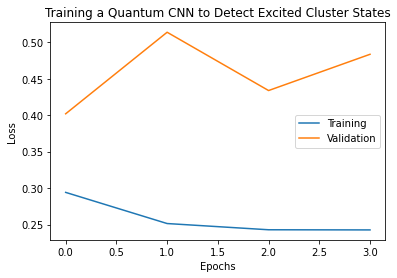

In [53]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
y_hat=hybrid_model.predict(x=x_train_tfcirc)

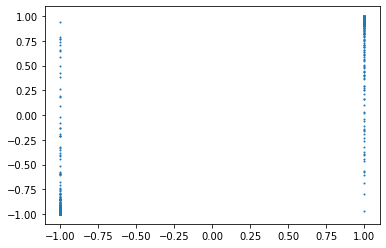

In [56]:
plt.scatter(y_train_hinge,y_hat,s=1)

In [0]:
tfq.util.get_supported_gates()

{cirq.CNOT: 2,
 cirq.CZ: 2,
 cirq.H: 1,
 cirq.I: 1,
 cirq.ISWAP: 2,
 cirq.PhasedXPowGate(phase_exponent=0.123): 1,
 cirq.PhasedISwapPowGate(phase_exponent=0.123): 2,
 cirq.SWAP: 2,
 cirq.X: 1,
 cirq.XX: 2,
 cirq.Y: 1,
 cirq.YY: 2,
 cirq.Z: 1,
 cirq.ZZ: 2,
 cirq.FSimGate(theta=0.123, phi=0.456): 2}